In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

## Data Preprocessing

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

data = {}
data['train'] = []
for i in xrange(10):
    data['train'].append([])
for i in xrange(len(mnist.train.images)):
    data['train'][np.argmax(np.array(mnist.train.labels[i]))].append(mnist.train.images[i])
for i in xrange(10):
    data['train'][i] = np.array(data['train'][i])

data['test'] = []
for i in xrange(10):
    data['test'].append([])
for i in xrange(len(mnist.test.images)):
    data['test'][np.argmax(np.array(mnist.test.labels[i]))].append(mnist.test.images[i])
for i in xrange(10):
    data['test'][i] = np.array(data['test'][i])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def prepare_data(normal_idx, prob_positive, set_name):
    dataset = []
    dataset.extend(data[set_name][normal_idx][::])
    total_positive = len(dataset)
    total_negitive = int((total_positive / prob_positive) * (1 - prob_positive))
    labelset = [1] * total_positive
    count_neg = 0
    for i in xrange(10):
        if i == normal_idx: continue
        count_neg += len(data[set_name][i])
    sample_rate = float(total_negitive) / count_neg
    for i in xrange(10):
        if i == normal_idx: continue
#         print("class {0}: {1}".format(i, int(data[set_name][i].shape[0] * sample_rate)))
        idx = np.random.choice(data[set_name][i].shape[0], int(data[set_name][i].shape[0] * sample_rate))
        dataset.extend(data[set_name][i][idx])
        labelset += [-1] * len(idx)
    dataset = np.array(dataset)
    assert len(dataset) == len(labelset)
    return dataset, labelset

training_data = []
training_label = []
testing_data = []
testing_label = []

def prepare(normal_idx, prob_positive):
    global training_data
    global training_label
    global testing_data
    global testing_label
    
    training_data, training_label = prepare_data(normal_idx, prob_positive, 'train')
    testing_data, testing_label = prepare_data(normal_idx, prob_positive, 'test')

In [5]:
# batch sampling
def next_batch(batch_size):
#     print(type(training_data[np.random.choice(training_data.shape[0], batch_size)]))
    return training_data[np.random.choice(training_data.shape[0], batch_size)]

## AutoEncoder Architecture

In [166]:
# Parameters
learning_rate = 0.01
training_epochs = 50
batch_size = 256
display_step = 1
examples_to_show = 10

prepare(3, 0.8)
# Network Parameters
n_hidden_1 = 16 # 1st layer num features
n_hidden_2 = 8 # 2nd layer num features
n_hidden_3 = 4 # 3rd layer num features
n_hidden_4 = 2 # 4th layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

In [167]:
# Building the encoder
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'encoder_h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_3])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h4': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b4': tf.Variable(tf.random_normal([n_input])),
}
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                               biases['encoder_b3']))
    
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                               biases['encoder_b4']))
    
    return layer_4


# Building the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_h4']),
                                   biases['decoder_b4']))
    return layer_4

In [168]:
def buildFCAE(X):
    encoder_op = encoder(X)
    return decoder(encoder_op)

In [169]:
def buildConvAE(x, n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3]):
    x_dim = np.sqrt(x.get_shape().as_list()[1])
    x_dim = int(x_dim)
    x_tensor = tf.reshape(
        x, [-1, x_dim, x_dim, n_filters[0]])
    current_input = x_tensor
    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # 
    # now have the reconstruction through the network
    y = current_input
    return y

In [170]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
y_true = tf.placeholder("float", [None, n_input])

# Prediction
y_pred = buildFCAE(X)
# Targets (Labels) are the input data.

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# define the adverial example generating routine
gradients = tf.gradients(cost, X)[0]
perturbations = 0.01 * tf.sign(gradients)
new_attack = X - perturbations

# Initializing the variables
init = tf.global_variables_initializer()

## Effectiveness of Autoencoder-based Anomaly Detecter

In [171]:
# Launch the graph
sess = tf.Session()
sess.run(init)
total_batch = int(mnist.train.num_examples / batch_size)

# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, y_true : batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

Epoch: 0001 cost= 0.096693330
Epoch: 0002 cost= 0.065192565
Epoch: 0003 cost= 0.063445188
Epoch: 0004 cost= 0.057151269
Epoch: 0005 cost= 0.056144558
Epoch: 0006 cost= 0.054974053
Epoch: 0007 cost= 0.054314412
Epoch: 0008 cost= 0.054099910
Epoch: 0009 cost= 0.051335849
Epoch: 0010 cost= 0.053817268
Epoch: 0011 cost= 0.051478259
Epoch: 0012 cost= 0.051475942
Epoch: 0013 cost= 0.049892347
Epoch: 0014 cost= 0.051159490
Epoch: 0015 cost= 0.051948979
Epoch: 0016 cost= 0.051895779
Epoch: 0017 cost= 0.049302232
Epoch: 0018 cost= 0.049400199
Epoch: 0019 cost= 0.051030800
Epoch: 0020 cost= 0.050815921
Epoch: 0021 cost= 0.050534926
Epoch: 0022 cost= 0.051801253
Epoch: 0023 cost= 0.049353078
Epoch: 0024 cost= 0.050680228
Epoch: 0025 cost= 0.050216362
Epoch: 0026 cost= 0.048497297
Epoch: 0027 cost= 0.049222879
Epoch: 0028 cost= 0.048956014
Epoch: 0029 cost= 0.048499312
Epoch: 0030 cost= 0.048021767
Epoch: 0031 cost= 0.046892900
Epoch: 0032 cost= 0.047972605
Epoch: 0033 cost= 0.047543909
Epoch: 003

In [172]:
def threshold(labels, errors):
    n = len(labels)
    data = sorted([(errors[i], labels[i]) for i in xrange(n)])
  
    nn, np, pn = 0, 0, 0
    for i in xrange(n):
        if data[i][1] == -1:
            nn += 1
        elif data[i][1] == 1:
            pn += 1

    f1 = []
    for i in xrange(n):
        if data[i][1] == -1:
            nn -= 1
            np += 1
        elif data[i][1] == 1:
            pn -= 1
        if nn == 0:
            continue
        rec = float(nn) / float(nn + pn)
        pre = float(nn) / float(nn + np)
        f1.append((2 / (1 / rec + 1 / pre), data[i][0]))
    return sorted(f1)[-1][1]

In [173]:
def f1(labels, errors, threshold):
    nn, np, pn = 0, 0, 0
    n = len(labels)
    for i in xrange(n):
        if labels[i] == -1 and errors[i] <= threshold:
            np += 1
        if labels[i] == -1 and errors[i] > threshold:
            nn += 1
        if labels[i] == 1 and errors[i] > threshold:
            pn += 1
    rec = float(nn) / float(nn + pn)
    print(rec)
    pre = float(nn) / float(nn + np)
    print(pre)
    return 2 / (1 / rec + 1 / pre)

In [174]:
def getError(set_name):
    if set_name == 'train':
        _set = training_data
    else:
        _set = testing_data
    error = []
    for i in xrange(len(_set)):
        temp_error = sess.run(cost, feed_dict={X: _set[i].reshape(1, -1), y_true: _set[i].reshape(1, -1)})
        error.append(temp_error)
    return error

In [175]:
t = threshold(training_label, getError('train'))
print(t)
print(f1(testing_label, getError('test'), t))

0.0546041
0.415204678363
0.574898785425
0.482173174873


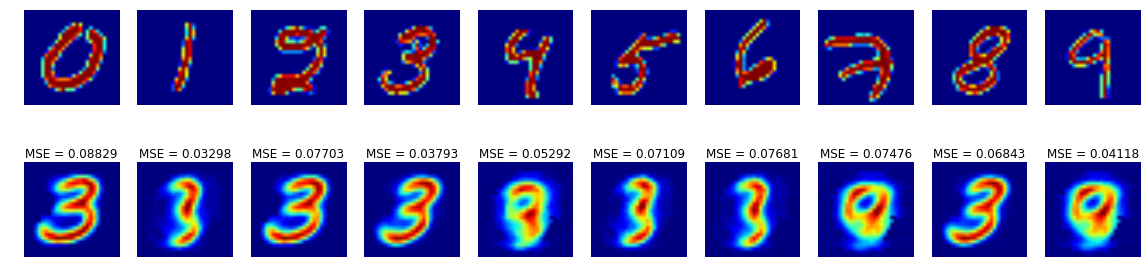

In [176]:
plt.figure(figsize = (20, 5))
for i in xrange(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.reshape(data['train'][i][0], (28, 28)))
    plt.axis("off")
    plt.subplot(2, 10, i + 11)
    _cost, recon = sess.run([cost, y_pred], feed_dict = {X: np.reshape(data['train'][i][0], (1, 784)), y_true: np.reshape(data['train'][i][0], (1, 784))})
    plt.imshow(np.reshape(recon, (28, 28)))
    plt.title("MSE = %.5f" % _cost)
    plt.axis("off")
plt.savefig("AE.pdf")

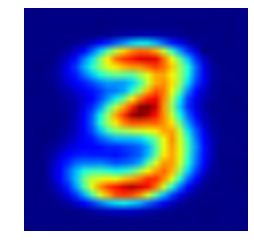

In [159]:
plt.imshow(np.reshape(data['train'][0][0], (28, 28)))
plt.axis("off")
plt.savefig("AE_origin.pdf")
_cost, recon = sess.run([cost, y_pred], feed_dict = {X: np.reshape(data['train'][0][0], (1, 784)), y_true: np.reshape(data['train'][i][0], (1, 784))})
plt.imshow(np.reshape(recon, (28, 28)))
plt.axis("off")
plt.savefig("AE_reconstructed.pdf")

## Generate the Adversarial Example

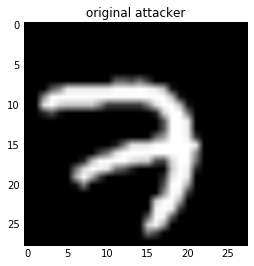

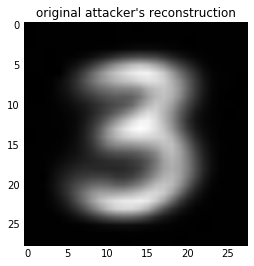

cost at iteration 1, 0.101122
cost at iteration 2, 0.101465
cost at iteration 3, 0.101584
cost at iteration 4, 0.101900
cost at iteration 5, 0.102059
cost at iteration 6, 0.102414
cost at iteration 7, 0.102561
cost at iteration 8, 0.102872
cost at iteration 9, 0.103430
cost at iteration 10, 0.103462
cost at iteration 11, 0.103281
cost at iteration 12, 0.103467
cost at iteration 13, 0.103287
cost at iteration 14, 0.103473
cost at iteration 15, 0.103293
cost at iteration 16, 0.103479
cost at iteration 17, 0.103300
cost at iteration 18, 0.103487
cost at iteration 19, 0.103309
cost at iteration 20, 0.103496
cost at iteration 21, 0.103318
cost at iteration 22, 0.103506
cost at iteration 23, 0.103329
cost at iteration 24, 0.103517
cost at iteration 25, 0.103340
cost at iteration 26, 0.103529
cost at iteration 27, 0.103353
cost at iteration 28, 0.103542
cost at iteration 29, 0.103366
cost at iteration 30, 0.103556
cost at iteration 31, 0.103381
cost at iteration 32, 0.103571
cost at iteration

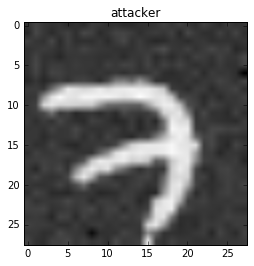

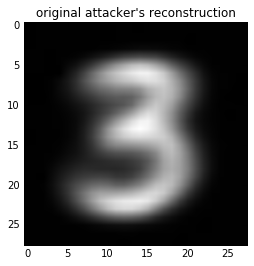

In [136]:
# get the attacker
# attacker = np.random.rand((28 * 28))
for i in xrange(len(mnist.train.images)):
#     print(mnist.train.labels[i])
    if mnist.train.labels[i][7] == 1:
        attacker = mnist.train.images[i]
        break

plt.imshow(np.reshape(attacker, (28, 28)), cmap='gray')
plt.title("original attacker")
plt.show()

reconstruction = sess.run(y_pred, feed_dict = {X: np.reshape(attacker, (1, 784)), y_true: np.reshape(attacker, (1, 784))})
plt.imshow(np.reshape(reconstruction, (28, 28)), cmap='gray')
plt.title("original attacker's reconstruction")
plt.show()

step = 0
t = threshold(training_label, getError('train'))
while True:
    step += 1
    attacker, _cost = sess.run([new_attack, cost], feed_dict={X: np.reshape(attacker, (1, 784)), y_true: np.reshape(attacker, (1, 784))})
    print("cost at iteration {0}, {1:.6f}".format(step, _cost))
    if _cost <= t: break
    if step > 100: 
        print("boom")
        break

plt.imshow(np.reshape(attacker, (28, 28)), cmap='gray')
plt.title("attacker")
plt.show()

reconstruction = sess.run(y_pred, feed_dict = {X: np.reshape(attacker, (1, 784)), y_true: np.reshape(attacker, (1, 784))})
plt.imshow(np.reshape(reconstruction, (28, 28)), cmap='gray')
plt.title("original attacker's reconstruction")
plt.show()

In [72]:
sess.close()